In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE =32
EPOCHS= 5
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "plantvillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
) 

Found 16011 files belonging to 10 classes.


In [11]:
#This will put dataset into one list  
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [12]:
len(dataset)

501

In [13]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 4 2 3 4 0 2 7 3 5 2 4 6 0 2 6 5 2 1 8 0 4 3 7 6 0 9 9 2 5 4]


In [14]:
#This prints the first image
#its a tensor and when you want to convert tensor to a numpy, this is what you do

for image_batch, label_batch in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[142. 146. 145.]
  [142. 146. 145.]
  [142. 146. 145.]
  ...
  [137. 142. 136.]
  [135. 140. 134.]
  [134. 139. 133.]]

 [[143. 147. 146.]
  [143. 147. 146.]
  [143. 147. 146.]
  ...
  [137. 142. 136.]
  [136. 141. 135.]
  [135. 140. 134.]]

 [[143. 147. 146.]
  [143. 147. 146.]
  [143. 147. 146.]
  ...
  [137. 142. 136.]
  [137. 142. 136.]
  [137. 142. 136.]]

 ...

 [[ 73.  68.  62.]
  [ 74.  69.  63.]
  [ 76.  71.  65.]
  ...
  [ 74.  71.  62.]
  [ 73.  70.  61.]
  [ 72.  69.  60.]]

 [[ 74.  69.  63.]
  [ 74.  69.  63.]
  [ 73.  68.  62.]
  ...
  [ 71.  68.  59.]
  [ 71.  68.  59.]
  [ 71.  68.  59.]]

 [[ 71.  66.  60.]
  [ 69.  64.  58.]
  [ 66.  61.  55.]
  ...
  [ 69.  66.  57.]
  [ 71.  68.  59.]
  [ 72.  69.  60.]]], shape=(256, 256, 3), dtype=float32)


In [15]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


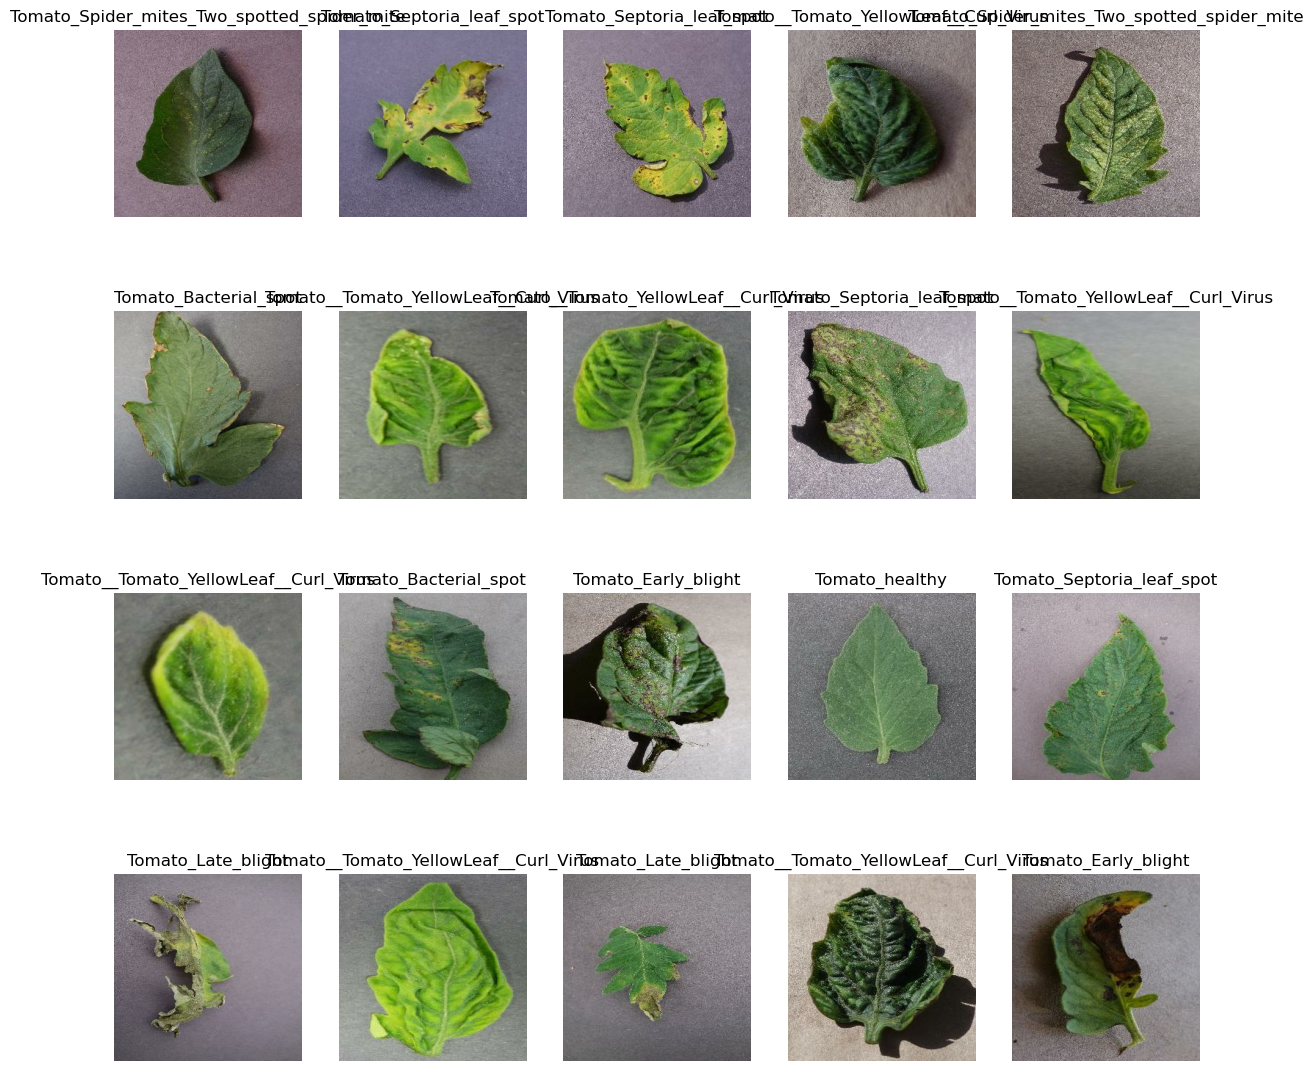

In [16]:
#to visualize, use matplot.lib
plt.figure(figsize=(14,14))
for image_batch, label_batch in dataset.take(1):
    for i in range(20):
        ax = plt.subplot(4,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [17]:
len(dataset)
#The rating to use
#80% ==> training
#20% ==> 10% validation, 10% test

501

In [18]:
#SK learn,we use the data test .take to cal the no of items to use
train_size = 0.8
len(dataset)*train_size

400.8

In [19]:
#this is to show we are about to use the first 54 data set representin 80%
train_ds = dataset.take(400)
len(train_ds)

400

In [20]:
test_ds = dataset.skip(400)
len(test_ds)

101

In [21]:
val_size = 0.1
len(dataset)*val_size

50.1

In [22]:
val_ds = test_ds.take(50)
len(val_ds)

50

In [23]:
test_ds = test_ds.skip(50)
len(test_ds)

51

In [24]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size = 10000):
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [25]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [26]:
len(train_ds)

400

In [27]:
len(test_ds)

51

In [28]:
len(val_ds)

50

In [29]:
#optimizing the dataset to make them run faster..watch de 2 recommended videos
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [30]:
#this is to scale down the image to limit it to btn 0 and 1
#resize all other images that are not 255
resize_and_rescale = tf.keras.Sequential([    
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [31]:
data_augmentation = tf.keras.Sequential([    
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [32]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
    
])
model.build(input_shape = input_shape)

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [35]:
history= model.fit(
    train_ds,
    epochs=5,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/5
400/400 [==============================] - 1467s 4s/step - loss: 1.5029 - accuracy: 0.4635 - val_loss: 1.5149 - val_accuracy: 0.5375
Epoch 2/5
400/400 [==============================] - 1476s 4s/step - loss: 0.8269 - accuracy: 0.7081 - val_loss: 1.5824 - val_accuracy: 0.5600
Epoch 3/5
400/400 [==============================] - 1945s 5s/step - loss: 0.6230 - accuracy: 0.7766 - val_loss: 0.6012 - val_accuracy: 0.7900
Epoch 4/5
400/400 [==============================] - 2153s 5s/step - loss: 0.4871 - accuracy: 0.8270 - val_loss: 0.6907 - val_accuracy: 0.7925
Epoch 5/5
400/400 [==============================] - 1550s 4s/step - loss: 0.4355 - accuracy: 0.8459 - val_loss: 0.8319 - val_accuracy: 0.7494


In [38]:
scores = model.evaluate(test_ds)


51/51 [==============================] - 38s 746ms/step - loss: 0.9008 - accuracy: 0.7335


In [39]:
scores

[0.9007532596588135, 0.7334558963775635]

In [40]:
history

In [41]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 400}

In [42]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [43]:
history.history.values()

dict_values([[1.50291109085083, 0.8269046545028687, 0.6229532957077026, 0.48708832263946533, 0.43552467226982117], [0.46351563930511475, 0.7081249952316284, 0.776562511920929, 0.826953113079071, 0.8459374904632568], [1.5148566961288452, 1.5824052095413208, 0.6012430787086487, 0.6907361745834351, 0.8318876624107361], [0.5375000238418579, 0.5600000023841858, 0.7900000214576721, 0.7925000190734863, 0.7493749856948853]])

In [44]:
history.history['accuracy']

[0.46351563930511475,
 0.7081249952316284,
 0.776562511920929,
 0.826953113079071,
 0.8459374904632568]

In [45]:
#plotting the history on matplotlib
acc=history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

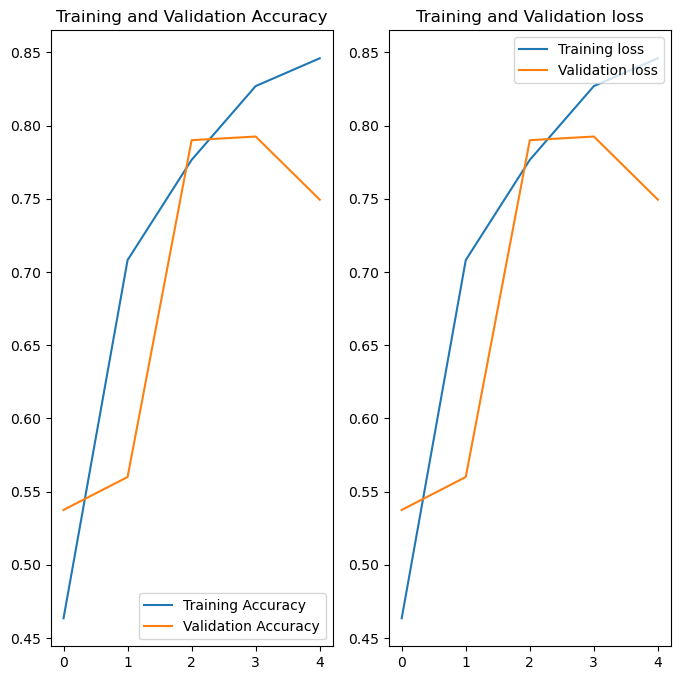

In [46]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label ='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label ='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), acc, label ='Training loss')
plt.plot(range(EPOCHS), val_acc, label ='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.show()

first image to predict
actual label: Tomato_Spider_mites_Two_spotted_spider_mite
1/1 [==============================] - 0s 405ms/step
predicted label: Tomato_healthy


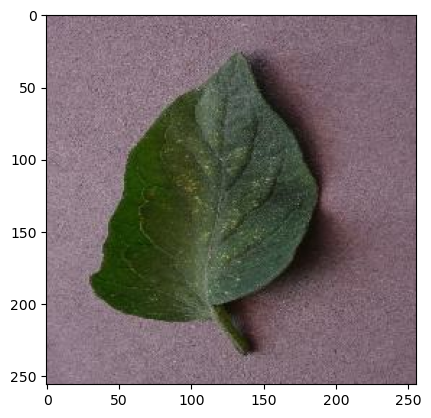

In [51]:
# we want to test the model further by using the first picture
#The model is perfect to an extent that it selects an actual and a related predicted case
#This is the power of convolutional neurone network
import numpy as np
for images_batch, labels_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [52]:
#this is a function meant for predicting how strong our model is:
def predict(mode, img):
    
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)#create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

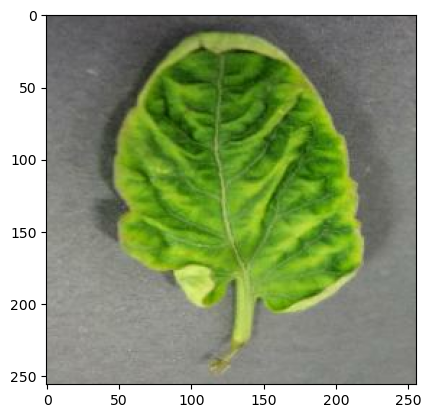

In [53]:
#To show one of the images:
for images, labels in test_ds.take(1):
    for i in range(9):
        plt.imshow(images[i].numpy().astype("uint8"))

1/1 [==============================] - 0s 42ms/step


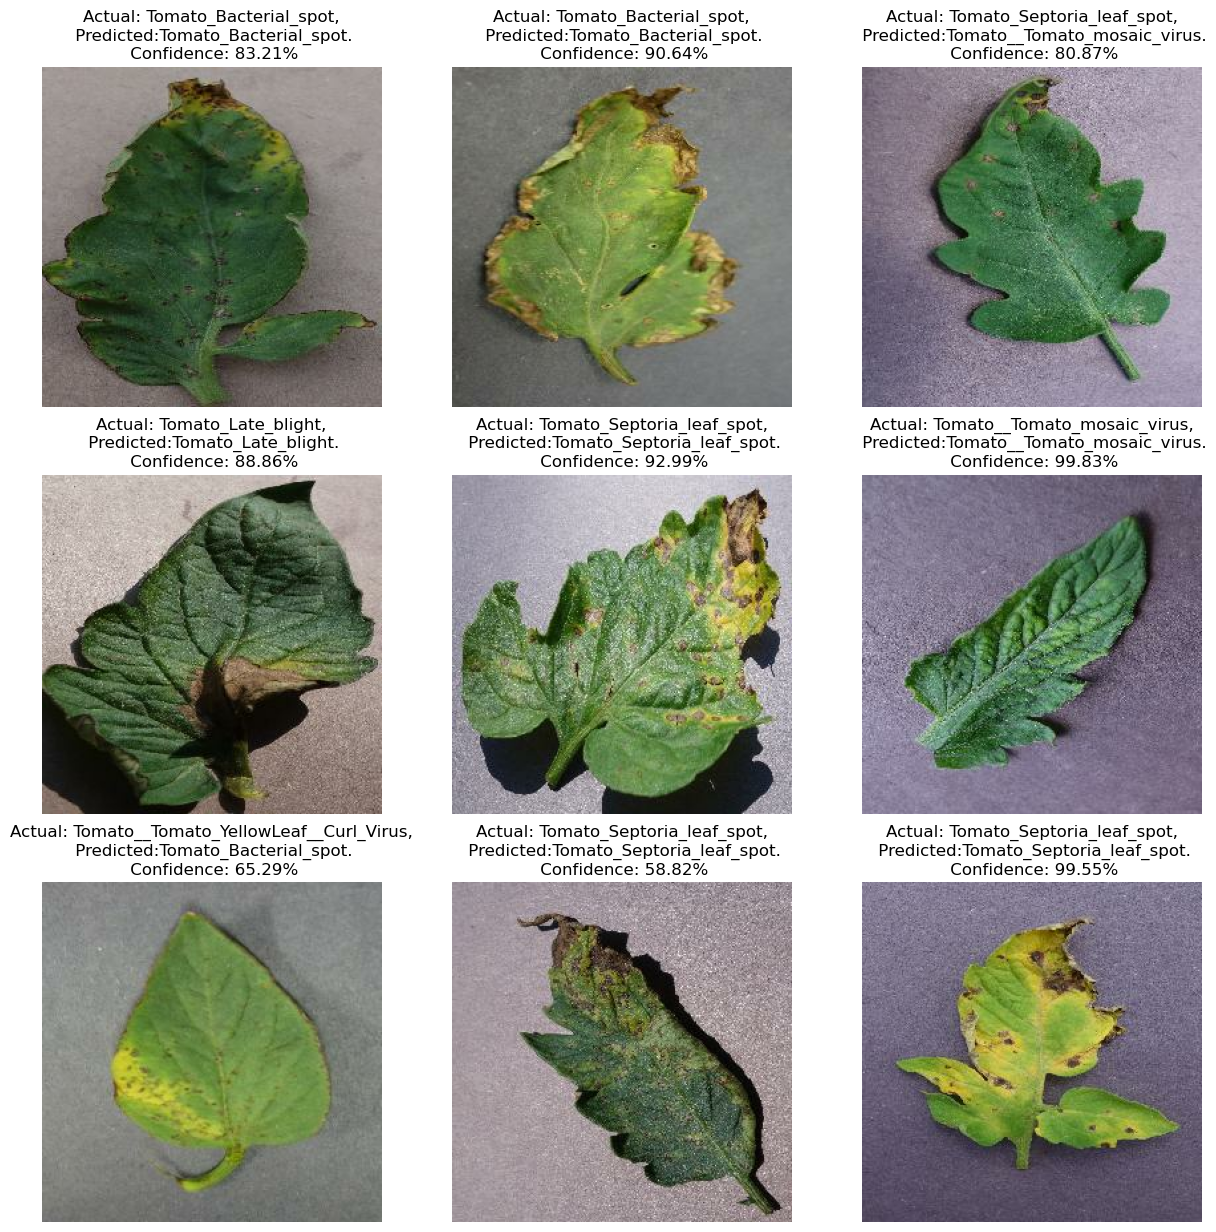

In [55]:
# I want to put a title, we call the predicted fxn, actual fxn & add the plot title
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax= plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted:{predicted_class}.\n Confidence: {confidence}%" )
        plt.axis("off")

In [56]:
model_version =1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1\assets


INFO:tensorflow:Assets written to: ./models/1\assets


In [57]:
#As a data scientist, assuming you want to edit your model  to reset some values, you can set it as model 2
model_version =2
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/2\assets


INFO:tensorflow:Assets written to: ./models/2\assets


In [58]:
#Also if you realize there is a model count and you
#want to save them, you can do that with OS
import os
os.listdir("./models")

['1', '2']

In [59]:
#it returned a string, convert it to an integer
#use lift comprehension
import os
[int(i) for i in os.listdir("./models")]

[1, 2]

In [60]:
#If you want to add another version
[int(i) for i in os.listdir("./models")+ [0]]

[1, 2, 0]

In [61]:
#to find the max of it
max([int(i) for i in os.listdir("./models")])+1

3

In [62]:
#if I want to save another version into the folder
#Each time you run the below code, It will increase the model 
model_version =max([int(i) for i in os.listdir("./models")])+1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/3\assets


INFO:tensorflow:Assets written to: ./models/3\assets


In [63]:
#Creating another model
model_version =max([int(i) for i in os.listdir("./models")])+1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/4\assets


INFO:tensorflow:Assets written to: ./models/4\assets
